# TF-IDF for database columns

This notebook describes applying TF-IDF to database columns. It generate some synthetic data, featurizers the data, applies TF-IDF and visualizes the results with t-SNE. There is a corresponding blog post at [LINK HERE]

#### Load some libraries and set some plotting configurations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", 
                rc={"font.size":8,"axes.labelsize":10,
                    "xtick.labelsize":10, "ytick.labelsize":10})

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

In [4]:
from collections import OrderedDict, Counter

In [5]:
from faker import Faker
fake = Faker()
fake.seed(101)

#### Some useful functions and variables

In [6]:
synthetic_data_factories = OrderedDict({"email": fake.email, 
             "phone_number": fake.phone_number, 
             "float_number": lambda: str(np.random.uniform(-180, 180)), 
             "binary_number": lambda: str(np.random.randint(0, 2)),
             "UUID": fake.uuid4})

In [7]:
placeholders = OrderedDict({"-": 1, "": 1, "0": 1})

In [8]:
def simulated_column_data(factory, num_rows, placeholders, placeholder_probability=0):
    column = []
    placeholder_selection_frequency = [
        val / sum(placeholders.values()) for val in placeholders.values()
    ]
    for _ in range(num_rows):
        is_placeholder = np.random.uniform(0, 1) < placeholder_probability
        placeholder_value = np.random.choice(
            list(placeholders.keys()), 
            size=1, 
            p=placeholder_selection_frequency)[0]
        if is_placeholder:
            cell_value = placeholder_value
        else:
            cell_value = factory()
        column.append(cell_value)
    return column

#### generate the synthetic data

In [9]:
dataframe_list = []
placeholder_prob = 0.9
columns_per_class = 20
labels = []
for data_class, synthetic_data_factory in synthetic_data_factories.items():
    for column_idx in range(columns_per_class):
        labels.append(data_class)
        
        df = pd.DataFrame(
            {"column_name": "{}{:03d}".format(data_class, column_idx+1),
             "data_class": data_class, 
             "cell_value": simulated_column_data(
                 synthetic_data_factory, 
                 100, 
                 placeholders, 
                 placeholder_prob
             )
            }
        )
        dataframe_list.append(df)
df = pd.concat(dataframe_list, axis=0)
labels = np.array(labels)

The most common values. Note that values are typically very common (placeholders) or unique (authentic data)

In [10]:
Counter(df.cell_value).most_common(10)

[('0', 3083),
 ('', 3057),
 ('-', 2950),
 ('1', 102),
 ('sanfordsandra@yahoo.com', 1),
 ('walkerkeith@hotmail.com', 1),
 ('kjones@carrillo.com', 1),
 ('richard31@torres-rodriguez.net', 1),
 ('nicole66@gmail.com', 1),
 ('robert73@reed-johnson.info', 1)]

#### Featurizers

In [11]:
import re
import uuid
import phonenumbers

def regex_feature(value, patt):
    return re.search(patt, value.strip().lower()) is not None
       
def matches_email(value):
    patt = (
        r"^([a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`{|}~-]+)*"
        # Doesn't start with a period
        r"(@|\sat\s)"  # requires `at` clause
        r"(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?"  # domain name doesn't start or end with a hyphen
        r"(\.|\sdot\s))+"  # one or more second level domains
        r"[a-z0-9](?:[a-z0-9-]*[a-z0-9])?)$"  # top level domain doesn't start or end in a hyphen
    )
    return regex_feature(value, patt)

def matches_uuid(value):
    try:
        uuid.UUID(value)
        return True
    except ValueError:
        return False

def matches_phone_number(value):
    regions = ["US", None]
    for region in regions:
        try:
            phone_number = phonenumbers.parse(value, region)
            if phonenumbers.is_valid_number(phone_number):
                return True
        except phonenumbers.NumberParseException:
            pass
    return False

def is_float(value):
    try:
        _ = float(value)
        return True
    except:
        return False

def is_int(value):
    try:
        _ = int(value)
        return True
    except:
        return False
    
def is_len1(value):
    return len(value) == 1


In [12]:
featurizers = OrderedDict({
    "email": matches_email,
    "uuid": matches_uuid,
    "phone_number": matches_phone_number,
    "is_float": is_float,
    "is_int": is_int,
    "is_len1": is_len1
})

In [13]:
def featurize(value, featurizers):
    return OrderedDict({feature_name: feature_value(value) for feature_name, feature_value in featurizers.items()})

def stringify_features(value, featurizers):
    return ''.join([str(int(binary_feature)) for binary_feature in featurize(value, featurizers).values()])

Here are a few examples of featurization

In [14]:
featurize("---", featurizers)

OrderedDict([('email', False),
             ('uuid', False),
             ('phone_number', False),
             ('is_float', False),
             ('is_int', False),
             ('is_len1', False)])

In [15]:
featurize("-", featurizers)

OrderedDict([('email', False),
             ('uuid', False),
             ('phone_number', False),
             ('is_float', False),
             ('is_int', False),
             ('is_len1', True)])

In [16]:
featurize("18005551212", featurizers)

OrderedDict([('email', False),
             ('uuid', False),
             ('phone_number', True),
             ('is_float', True),
             ('is_int', True),
             ('is_len1', False)])

An example of stringifying a feature set

In [17]:
stringify_features("18005551212", featurizers)

'001110'

Apply the featurizers to the data and update the data frame. The Boolean features are turned into strings of 0 and 1 values which then form the **words** of our document set.

In [18]:
df.loc[:, "word"] = df.cell_value.apply(lambda x: stringify_features(x, featurizers))

The most common feature words. Note that the bifurcation into placeholders and unique values has been removed.

In [19]:
Counter(df.word).most_common()

[('000000', 3186),
 ('000111', 3185),
 ('000001', 2950),
 ('000100', 209),
 ('100000', 202),
 ('010000', 191),
 ('001000', 56),
 ('000110', 21)]

#### Generating documents

Here we generate documents composed of feature words 

In [20]:
# for actual terms
docs_value = []
for column_name in df.column_name.unique():
    docs_value.append(
        list(
            df.query("column_name == \"{}\"".format(column_name)).cell_value
        )
    )

In [21]:
# for feature words
docs_words = []
for column_name in df.column_name.unique():
    docs_words.append(
        list(
            df.query("column_name == \"{}\"".format(column_name)).word
        )
    )

In [22]:
# for unique values, i.e. sub-linear (binary) term frequency 
docs_unique = []
for column_name in df.column_name.unique():
    docs_unique.append(
        list(
            np.unique(df.query("column_name == \"{}\"".format(column_name)).word)
        )
    )

#### TF-IDF vectorization

In [23]:
# need an identity function to pass to TF-IDF 
# since we've already parsed the terms into documents
def identity_fun(x):
    return x

Here define the TF-IDF vectorizer. The relevant arguments are:

* `analyzer`: we analyze at the word level, as opposed to character n-gram level
* `preprocessor`: function to preprocess the values. Because we've already processed them, the identity function is used.
* `tokenzier`: function to tokenize the values. Because we've already tokenized them, the identity function is used.
* `token_pattern`: regular expression to tokenize the inputs. Because we've already tokenized them, the identity function is used.
* `sublinear_tf`: Boolean to apply sublinear (logarithmic) term-frequency. A sublinear (binary) term-frequency is more appropriate for this problem so we apply it in a preporocessing step below. 
* `smooth_idf`: Boolean to apply smooth inverse-document-frequency. 

In [24]:
# Instantiate the TF-IDF vectorizer
tfidf_mod = TfidfVectorizer(
    analyzer='word',
    preprocessor=identity_fun,
    tokenizer=identity_fun,
    token_pattern=None,
    sublinear_tf=False,
    smooth_idf=True
)

In [25]:
# generate the TF-IDF vectors for each of the three variations of document
tfidf_value = tfidf_mod.fit_transform(docs_value)
tfidf_words = tfidf_mod.fit_transform(docs_words)
tfidf_unique = tfidf_mod.fit_transform(docs_unique)

#### T-SNE plotting

Here we apply t-distributed stochastic neighbor embedding (t-SNE) to the TF-IDF vectors to visualize similarities. This algorithm provides a way of visualizing similarities between points in a high dimensional space by projecting them to a lower dimensional space (e.g. 2-dimensions) while approximately maintaining relative distances. 

In [26]:
tsne_mod = TSNE(metric="cosine", perplexity=20)

The actual-terms documents

In [27]:
Y = tsne_mod.fit_transform(tfidf_value.todense())

In [28]:
pl_df = pd.DataFrame(Y).rename(columns={0: "x1", 1: "x2"})
pl_df = pl_df.assign(data_class = labels)
pl_df.to_csv("tsne_terms.csv", index=False)

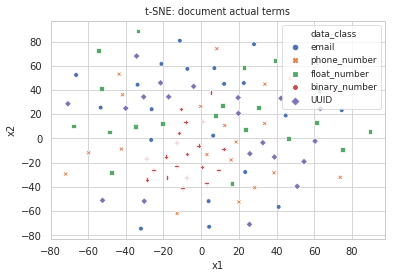

In [29]:
sns.scatterplot(x="x1", y="x2", hue="data_class", style="data_class", data=pl_df)
plt.title("t-SNE: document actual terms")

The feature-words documents

In [30]:
Y = tsne_mod.fit_transform(tfidf_words.todense())

In [31]:
pl_df = pd.DataFrame(Y).rename(columns={0: "x1", 1: "x2"})
pl_df = pl_df.assign(data_class = labels)
pl_df.to_csv("tsne_tfidf.csv", index=False)

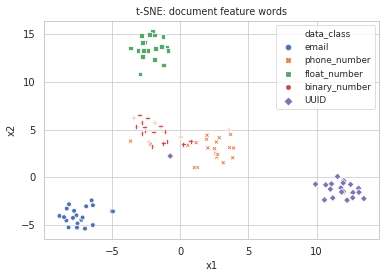

In [32]:
a = sns.scatterplot(x="x1", y="x2", hue="data_class", style="data_class", data=pl_df)
plt.title("t-SNE: document feature words")

The feature-words documents with sub-linear (binary) term frequencies

In [33]:
Y = tsne_mod.fit_transform(tfidf_unique.todense())

In [34]:
pl_df = pd.DataFrame(Y).rename(columns={0: "x1", 1: "x2"})
pl_df = pl_df.assign(data_class = labels)
pl_df.to_csv("tsne_tfidf_uniq.csv", index=False)

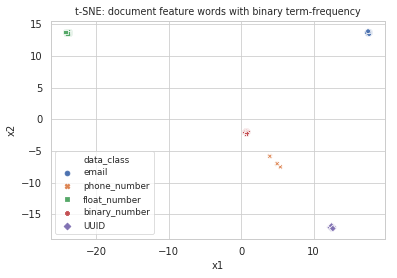

In [35]:
a = sns.scatterplot(x="x1", y="x2", hue="data_class", style="data_class", data=pl_df)
plt.title("t-SNE: document feature words with binary term-frequency")

The inverse-document values for the feature words, and the actual terms

In [36]:
tfidf_mod.fit_transform(docs_words)
tfidf_mod.idf_

array([1.        , 1.        , 2.57059808, 2.90707032, 1.        ,
       2.67068154, 2.57059808, 2.57059808])

In [37]:
tfidf_mod.fit_transform(docs_value)
tfidf_mod.idf_[0:5]

array([1.        , 4.92197334, 4.92197334, 4.92197334, 4.92197334])